# Studying FEL UQ - Creating Basic NN Models with Quantile Regression

### In this notebook, the following is done: 
A surrogate model of FEL pulse energy at the SLAC LCLS is trained on archiver (historical) data. The data spans several years of operation. The dataset inputs several accelerator "inputs" which result in an "output" pulse energy.

In [2]:
%load_ext autoreload
%autoreload 2


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import basicFunctions as bf
import pickle

### Colorblind friendly colors:

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]


import matplotlib.style
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 10}
mpl.rc('font', **font)


import QuantRegUtils as qru

#### Load Data

In [3]:
PATH = "datasets/"
NAME = "compiled_"
inputdf = pd.read_csv(PATH + NAME +'X.csv') 
outputdf = pd.read_csv(PATH + NAME + 'Y.csv') 

#### Take a look at the input variables

In [4]:
variable_names = inputdf.columns[1:]

output_names = outputdf.columns[1:]

view = False
## View the names and indicies of each variable
if view:
    for i, v in enumerate(variable_names):
        print(i, v)

#### Data manipulations

The following cell converts the dataframe to numpy arrays and applies the following cuts to the data: 

1) Removing extraneous data: no output values should be less than 0 (units) or greater than 5 (units).


In [5]:
input_data = inputdf.to_numpy()
output_data = outputdf.to_numpy()
## Removing "index column"
output_data = output_data[:,1]

print("Original shape of data, before cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

mask = np.where(np.logical_and(output_data>0, output_data<5))

## apply mask and cut out "index column"

removed_perc = 100*(np.shape(output_data)[0] - np.shape(output_data[mask])[0])/(np.shape(output_data)[0] )

input_data = input_data[mask[0], 1:]
output_data = output_data[mask]

print("Removed {:2f}% of full dataset, eliminating extraneous values".format(removed_perc))



print("Final shape of data, after cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))


Original shape of data, before cutting out extraneous data or selected HXR samples:
Input values: (286923, 77)
Output values: (286923,)
Removed 0.646515% of full dataset, eliminating extraneous values
Final shape of data, after cutting out extraneous data or selected HXR samples:
Input values: (285068, 76)
Output values: (285068,)


#### Scaling information will be needed later, should be saved and set up for use in training and model eval.

In [6]:
PATH = ""
MODEL_NAME = "BaseModels/"
loading = True
if loading:
    x_scales = np.load(PATH + MODEL_NAME + "x_scales.npy")
    x_offsets = np.load(PATH + MODEL_NAME +"x_offsets.npy")
    y_scale = np.load(PATH + MODEL_NAME +"y_scale.npy")
    y_offset = np.load(PATH + MODEL_NAME +"y_offset.npy")
    x_scaled = np.load(PATH + MODEL_NAME + "x_scaled.npy")
    y_scaled = np.load(PATH + MODEL_NAME + "y_scaled.npy")
else:
    x_scaled, x_scales, x_offsets = bf.do_scaling(input_data, -1, 1)
    y_offset, y_scale= bf.get_scale(output_data)

    y_scaled = bf.scale_data(output_data, y_offset, y_scale, -1,1)
    
    np.save(PATH + MODEL_NAME + "x_scales.npy", x_scales)
    np.save(PATH + MODEL_NAME + "x_offsets.npy", x_offsets)
    np.save(PATH + MODEL_NAME + "y_scale.npy", y_scale)
    np.save(PATH + MODEL_NAME + "y_offset.npy", y_offset)
    np.save(PATH + MODEL_NAME + "x_scaled.npy", x_scaled)
    np.save(PATH + MODEL_NAME + "y_scaled.npy", y_scaled)

x, y, d = qru.scaling_and_dict(input_data, output_data)

#### Examine Data

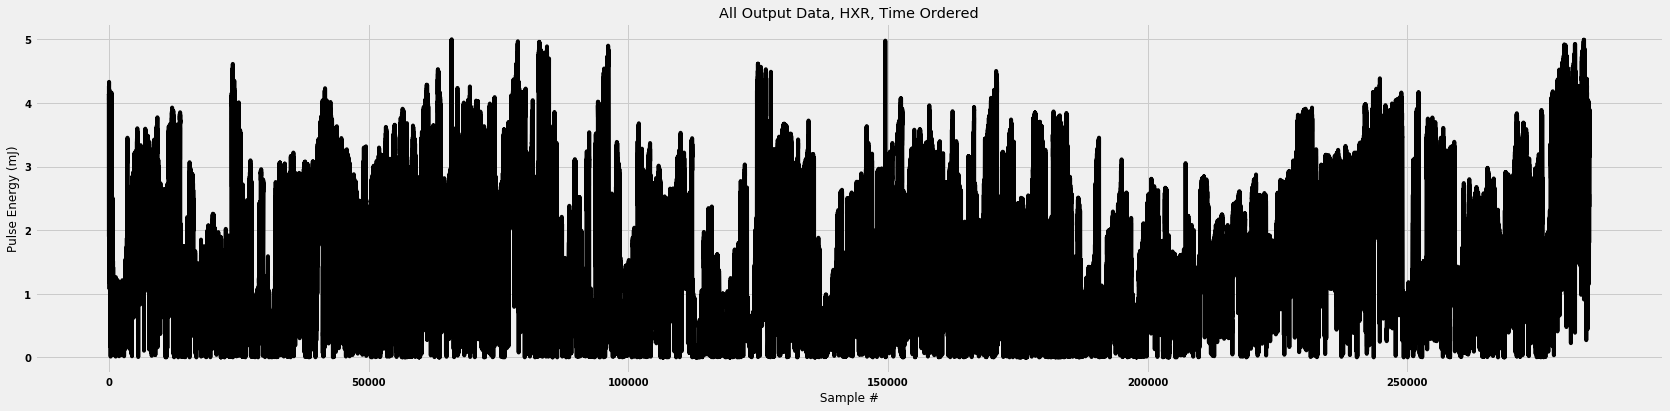

In [7]:
## Take a look at all of the output data
plt.figure(figsize= (26,6))
plt.plot(output_data, color = colors[0])
plt.ylabel("Pulse Energy (mJ)")
plt.xlabel(" Sample # ")
plt.title("All Output Data, HXR, Time Ordered")
plt.show()

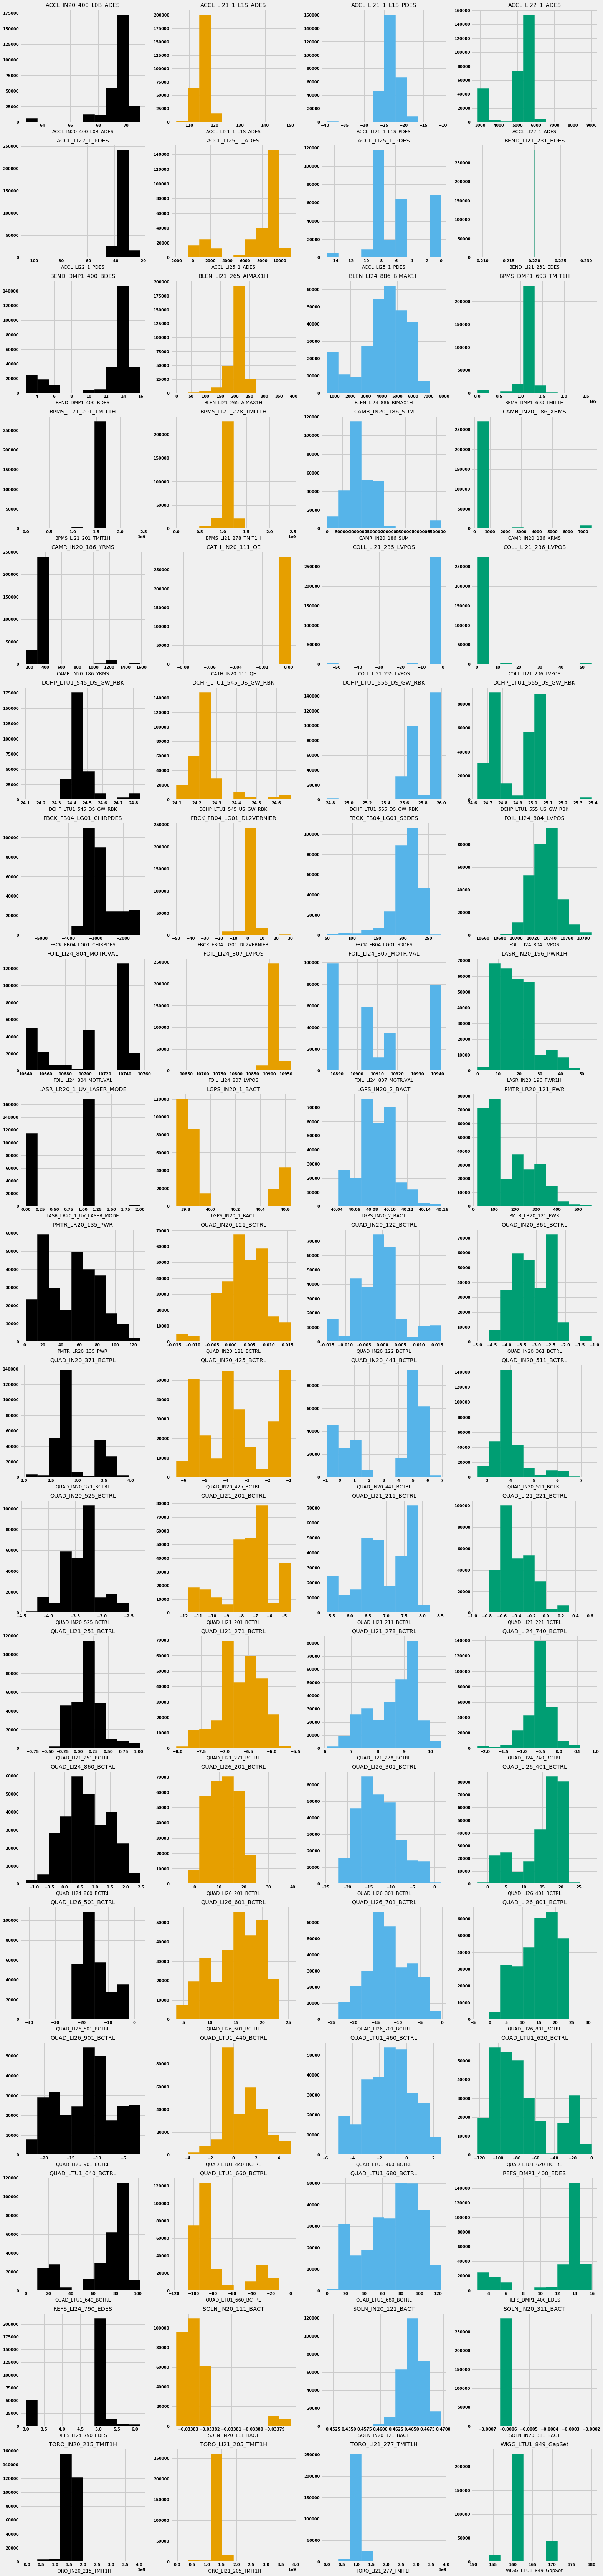

In [8]:
fig, axs = plt.subplots(19, 4, figsize = (24,int(6*19)))
counter = 0
for i in range(19):
    for j in range(4):

        axs[i,j].hist(input_data[:,counter], facecolor = colors[j], ec= colors[j])
        axs[i,j].set_title(variable_names[counter])
        axs[i,j].set_xlabel(variable_names[counter])
        counter = counter + 1
        plt.suptitle("")

plt.show()

## Training the Base Models

To make a nice apples-to-apples comparison, each model will be trained on the same data. Then we can see how well it performs on the same test samples!

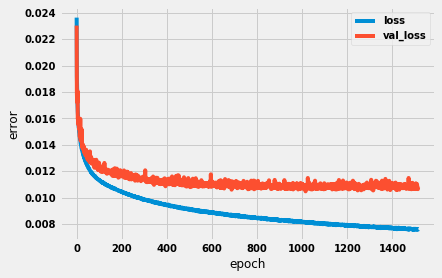

Time to run in minutes was:  28.896767461299895
Training Complete
Completed


In [10]:
training_models = True

if training_models:

    X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data, test_size = 0.2, random_state = 42)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)

    input_dict = {}
    input_dict["train"] = X_train
    input_dict["val"] = X_val
    input_dict["test"] = X_test

    output_dict = {}
    output_dict["train"] = Y_train
    output_dict["val"] = Y_val
    output_dict["test"] = Y_test

    with open(PATH + "BaseModels/inputs.pkl", 'wb') as f:
        pickle.dump(input_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(PATH + "BaseModels/outputs.pkl", 'wb') as f:
        pickle.dump(output_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    #### Set up some parameters
    epochs = 5000
    batch_size = 4096
    PATH = "/global/cfs/cdirs/m669/lgupta/datasets/FEL/BaseModels/"

    median = qru.Model(scaling_dict = d, PATH = PATH, NAME = "median_pred_", QUANTILE = 0.5)
    median.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)
    print("Completed")

    upper = qru.Model(scaling_dict = d, PATH = PATH, NAME = "upper_pred_", QUANTILE = 0.975)
    upper.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)
    print("Completed")

    lower = qru.Model(scaling_dict = d, PATH = PATH, NAME = "lower_pred_", QUANTILE = 0.025)
    lower.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)
    print("Completed")
else:

    PATH = "/global/cfs/cdirs/m669/lgupta/datasets/FEL/"
    MODEL_NAME = "BaseModels/"
    NN = MODEL_NAME + "median_pred_Model_Weights.h5"
    LB = MODEL_NAME + "lowerbound_Model_Weights.h5"
    UB = MODEL_NAME + "upperbound_Model_Weights.h5"

    with open(PATH + "BaseModels/inputs.pkl", 'r') as f:
        input_dict = pickle.load(f)

    with open(PATH + "BaseModels/outputs.pkl", 'r') as f:
        output_dict = pickle.load(f)

    median = qru.Model(PATH = PATH, NAME = NN, scaling_dict = d)   
    median.load()

    upper = qru.Model(PATH = PATH, NAME = UB, scaling_dict = d)   
    upper.load()

    lower = qru.Model(PATH = PATH, NAME = LB, scaling_dict = d)   
    lower.load()

    


    
    

Let's look at the performance!!

In [11]:
out = output_dict["test"]
median_pred = median.evaluate(input_dict["test"])
ub_pred = upper.evaluate(input_dict["test"])
lb_pred = lower.evaluate(input_dict["test"])


Do our 95% confidence intervals actually include 95% of the measurements?

In [12]:
coverage = np.logical_and(out > lb_pred[:,0], out < ub_pred[:,0])
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(out)

print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))

The percent of measured values within the confidence interval is: 92.84%


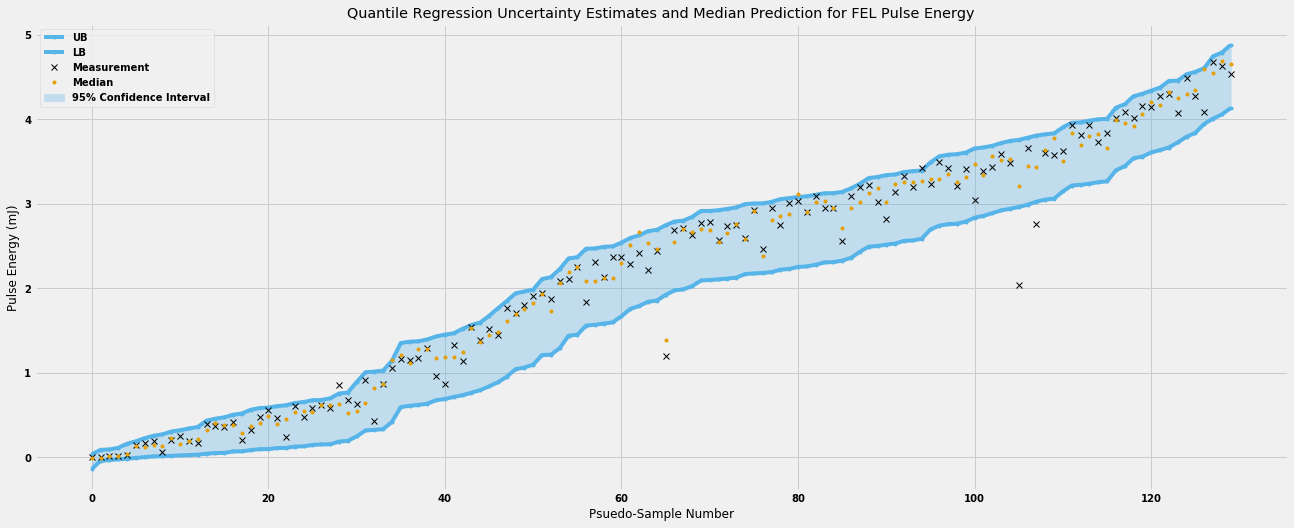

In [13]:
qru.plot_sorted_predictions(ub_pred, lb_pred, median_pred, out)

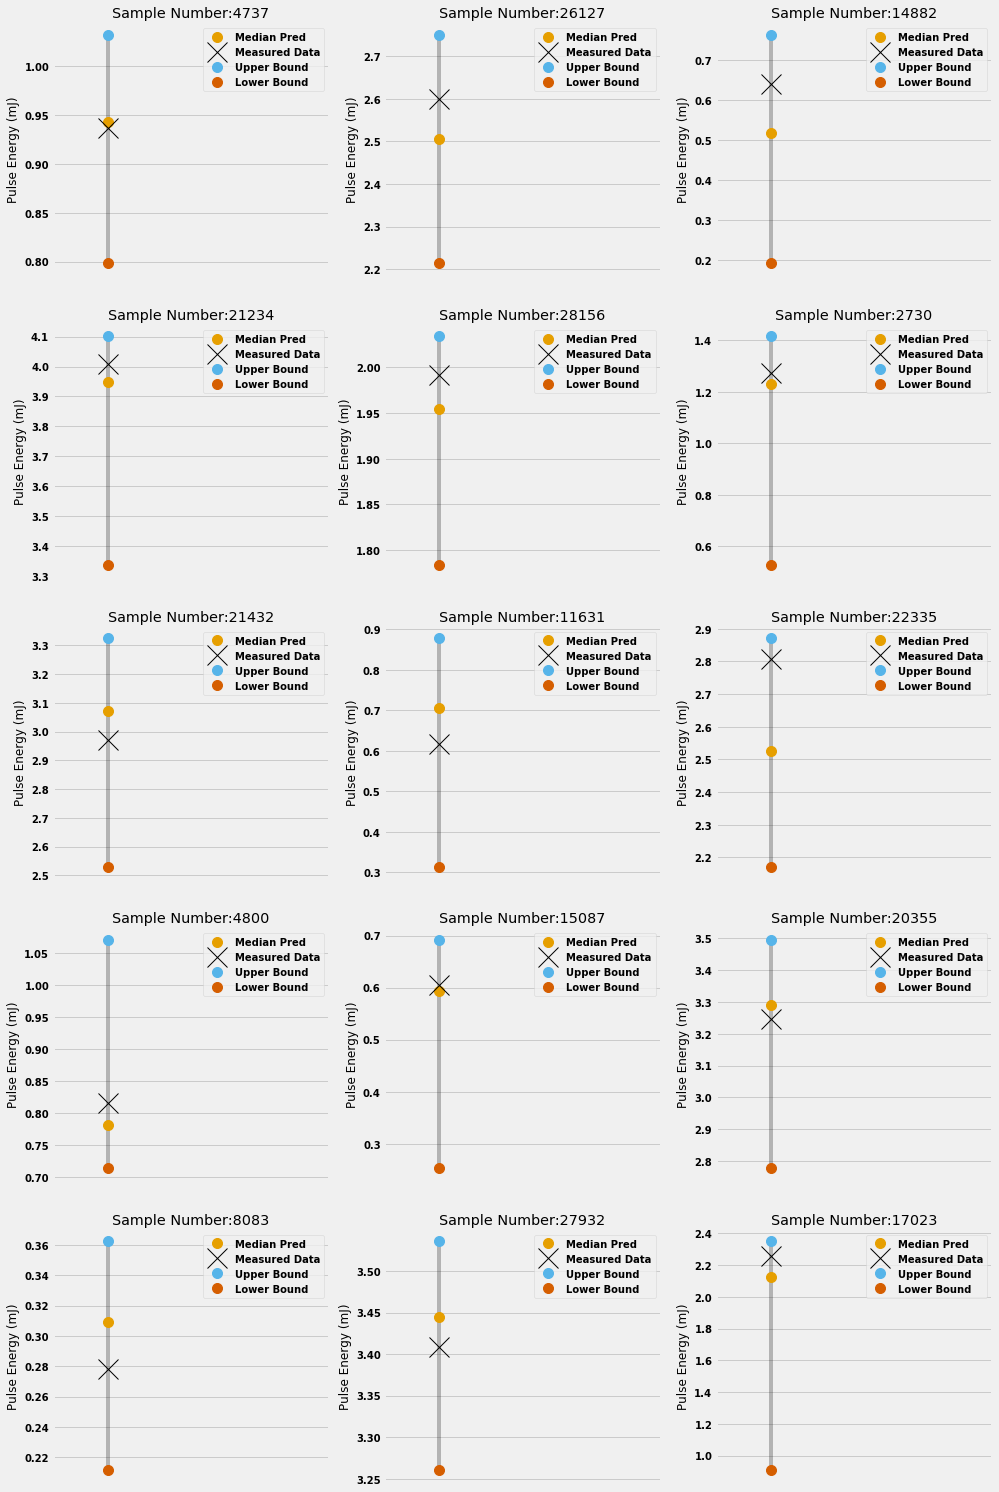

In [19]:
qru.plot_individual_points(ub_pred, lb_pred, median_pred, out)

And finally, some errors: mean squared error and mean absolute error. Remember, we want these to be small! :)

In [20]:
mse, mae = qru.calc_mse_and_mae(median_pred[:,0], out)
print(mse)
print(mae)

0.07196399846499726
0.12539445218038814


## Quad Scans

These are not realllllly the quad scans we want, these are more just going through the data and sorting on a specific quad value. An actual quad scan would hold all of the other 75 inputs constant and just vary one quad at a time. Lipi is working on this!

In [ ]:
quad_scan = qru.perform_quad_scan(45, input_data[20000:30000,:], output_data[20000:30000], median, upper, lower)

In [ ]:
inds, inps, meas, median_pred, ub_pred, lb_pred = quad_scan

In [ ]:
qru.plot_sorted_predictions(ub_pred, lb_pred, median_pred, meas)

### Quad Scans at a Specific Beam Energy

Just to be sure, lets make sure we are grabbing all of the data, and then making cuts to specific beam energies.

In [21]:
## the dataframes are untouched, so we'll just start there. 
input_data = inputdf.to_numpy()
output_data = outputdf.to_numpy()
## Removing "index column"
output_data = output_data[:,1]

print("Original shape of data, before cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

mask = np.where(np.logical_and(output_data>0, output_data<5))

## apply mask and cut out "index column"

removed_perc = 100*(np.shape(output_data)[0] - np.shape(output_data[mask])[0])/(np.shape(output_data)[0] )

input_data = input_data[mask[0], 1:]
output_data = output_data[mask]

print("Removed {:2f}% of full dataset, eliminating extraneous values".format(removed_perc))



print("Final shape of data, after cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

Original shape of data, before cutting out extraneous data or selected HXR samples:
Input values: (286923, 77)
Output values: (286923,)
Removed 0.646515% of full dataset, eliminating extraneous values
Final shape of data, after cutting out extraneous data or selected HXR samples:
Input values: (285068, 76)
Output values: (285068,)


Let's look at the beam energies present in the dataset (you can scroll up to the histograms, or we can make it again for easy reference:)

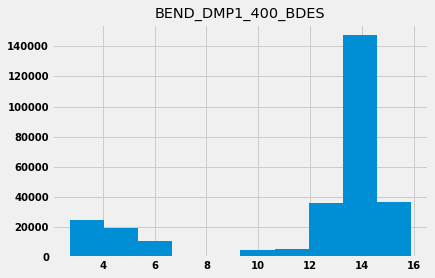

In [22]:
energy_column = 8
plt.hist(input_data[:,energy_column])
plt.title(variable_names[energy_column])
plt.show()

In the HXR region, let's take a better look at the distribution (we can just remove the low energy data for now.)

In [23]:
mask = np.where(input_data[:,energy_column] > 14)

input_data = input_data[mask[0],:]
output_data = output_data[mask]
n = np.shape(output_data)[0]


print("Final shape of data with beam energy > 10GeV:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

Final shape of data with beam energy > 10GeV:
Input values: (162619, 76)
Output values: (162619,)


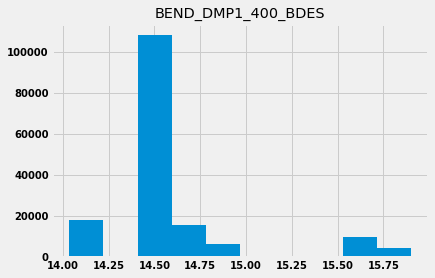

In [24]:
plt.hist(input_data[:,energy_column])
plt.title(variable_names[energy_column])
plt.show()

Looks like most of it is ~ 14.5 GeV

Let's select again:

In [25]:
mask = np.where(np.logical_and(input_data[:,energy_column] > 14.4,input_data[:,energy_column] < 14.6))

input_data = input_data[mask[0],:]
output_data = output_data[mask]
n = np.shape(output_data)[0]


print("Final shape of data with beam energy:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

Final shape of data with beam energy:
Input values: (111459, 76)
Output values: (111459,)


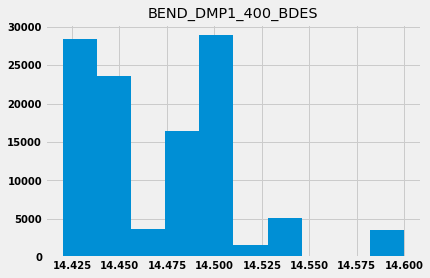

In [26]:
plt.hist(input_data[:,energy_column])
plt.title(variable_names[energy_column])
plt.show()

Let's check how the model performs in a quad scan, if we select on very narrow ranges within this primary operating range.

In [27]:
mask = np.where(np.logical_and(input_data[:,energy_column] > 14.4,input_data[:,energy_column] < 14.45))

input_ = input_data[mask[0],:]
output_ = output_data[mask]
n = np.shape(output_data)[0]


print("Final shape of data with beam energy cuts:")
print("Input values: " + str(np.shape(input_)))
print("Output values: " + str(np.shape(output_)))

Final shape of data with beam energy cuts:
Input values: (48531, 76)
Output values: (48531,)


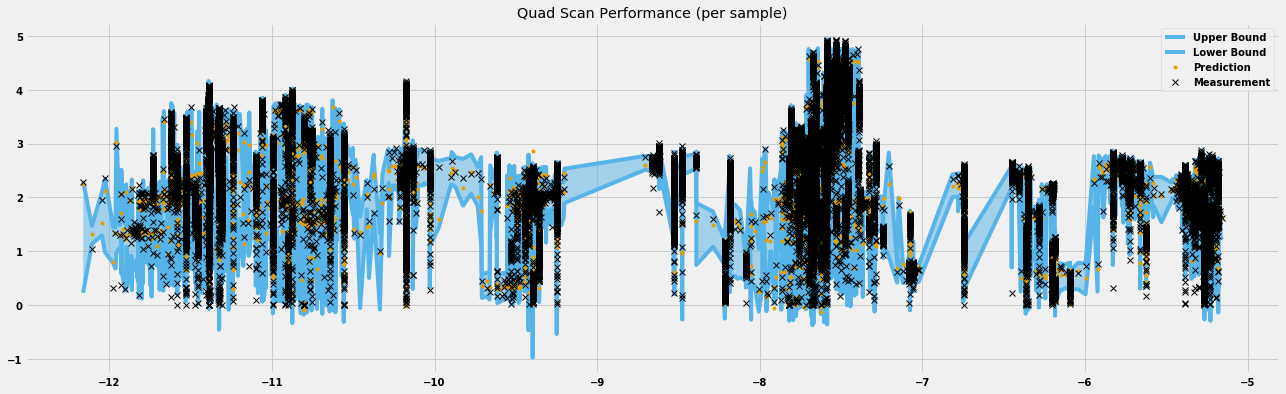

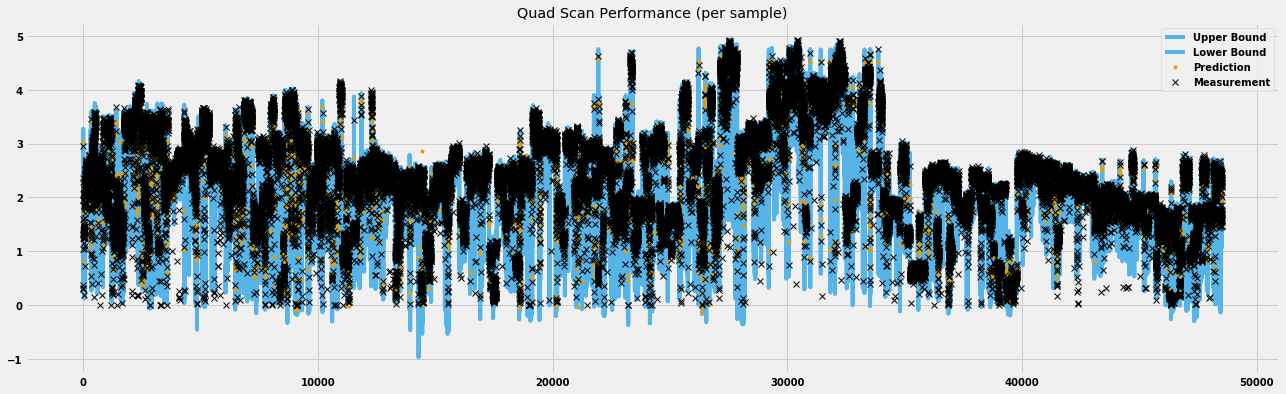

In [28]:
quad_scan = qru.perform_quad_scan(45, input_, output_, median, upper, lower)

In [29]:
mask = np.where(input_data[:,energy_column] == 14.5)

input_ = input_data[mask[0],:]
output_ = output_data[mask]
n = np.shape(output_data)[0]


print("Final shape of data with beam energy cuts:")
print("Input values: " + str(np.shape(input_)))
print("Output values: " + str(np.shape(output_)))

Final shape of data with beam energy cuts:
Input values: (10867, 76)
Output values: (10867,)


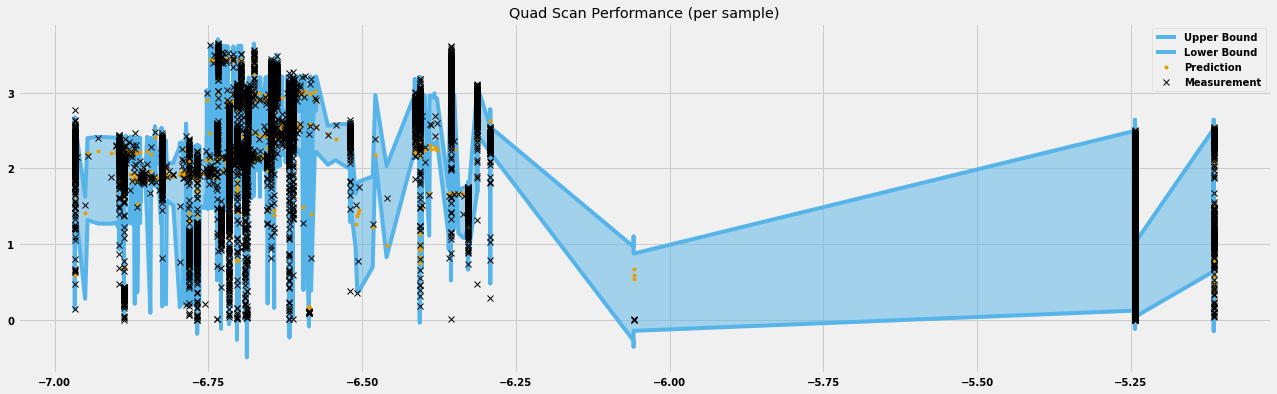

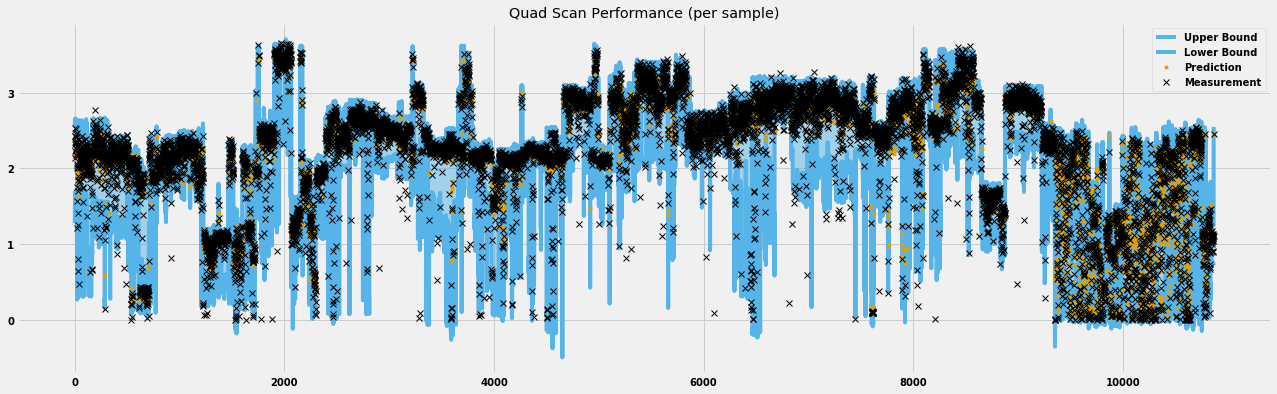

In [30]:
quad_scan = qru.perform_quad_scan(45, input_, output_, median, upper, lower)